# Mapping King County w/ Opportunity Youth Population Figures

This notebook describes the process of importing and cleaning King County Washington map data, and then plotting into a figure used in our report

## Load necessary packages

In [1]:
# make sure you are in oy-env environment
%matplotlib inline
import geopandas as gpd
from matplotlib import pyplot as plt
import pandas as pd

## Load necessary data and process for mapping

In [2]:
# Import Washington PUMA Data with GeoPandas Shape data in Geometry column
wa_puma = gpd.read_file("../../data/raw/tl_2017_53_puma10.shp") 

# Converts PUMACE10 Column from string to integer
wa_puma.loc[:,'PUMACE10'] = wa_puma['PUMACE10'].astype(int)
wa_puma.loc[:,'GEOID10'] = wa_puma['GEOID10'].astype(int)

In [3]:
wa_puma.head()

,STATEFP10,PUMACE10,GEOID10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,53,10200,5310200,"Skagit, Island & San Juan Counties PUMA",G6120,S,5470622131,2441658886,+48.4470835,-122.1737477,"POLYGON ((-122.44422 48.64527, -122.43685 48.6..."
1,53,10100,5310100,Whatcom County--Bellingham City PUMA,G6120,S,5459332804,1028183246,+48.8426531,-121.8364325,"POLYGON ((-122.40642 49.00230, -122.40617 49.0..."
2,53,10400,5310400,"Stevens, Okanogan, Pend Oreille & Ferry Counti...",G6120,S,29389124389,489162432,+48.5031090,-118.7866777,"POLYGON ((-118.14859 47.88667, -118.14899 47.8..."
3,53,10504,5310504,Spokane County (Outer)--Cheney City PUMA,G6120,S,3983412021,35812133,+47.5972847,-117.1210417,"POLYGON ((-117.10528 47.61018, -117.10527 47.6..."
4,53,10503,5310503,Spokane County (East Central)--Greater Spokane...,G6120,S,270926976,5004332,+47.6561281,-117.1818649,"POLYGON ((-117.15534 47.69971, -117.15509 47.6..."


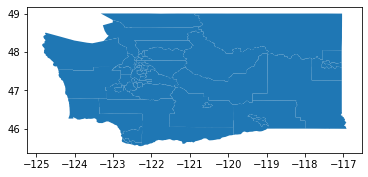

In [4]:
wa_puma.plot()
plt.show()

We can scrape from this [site](https://www.zipcodestogo.com/Washington/) the zipcodes of each Washington city 

In [5]:
data = pd.read_html('https://www.zipcodestogo.com/Washington/')

In [6]:
df_zips = data[1].copy()
df_zips.head()

,0,1,2,3
0,Zip Codes for the State of Washington,Zip Codes for the State of Washington,Zip Codes for the State of Washington,Zip Codes for the State of Washington
1,Zip Code,City,County,Zip Code Map
2,98001,Auburn,King,View Map
3,98002,Auburn,King,View Map
4,98003,Federal Way,King,View Map


In [7]:
df_zips.drop(0, inplace=True)
df_zips.drop(3, inplace=True, axis=1)
df_zips.columns = df_zips.loc[1].to_list()
df_zips.drop(1, inplace=True)
df_zips.reset_index(inplace=True, drop=True)
df_zips.head()

,Zip Code,City,County
0,98001,Auburn,King
1,98002,Auburn,King
2,98003,Federal Way,King
3,98004,Bellevue,King
4,98005,Bellevue,King


From [here](https://www.kingcounty.gov/depts/health/data/community-health-indicators/definitions.aspx) I get the South King County cities -> Auburn, Burien, Covington, Des Moines, Enumclaw, Federal Way, Kent, Maple Valley, Normandy Park, Renton, Tukwila, SeaTac, White Center/Boulevard Park, and Vashon Island.

In [8]:
df_zips = df_zips[df_zips.City.isin(['Auburn','Federal Way','Enumclaw','Burien','Covington','Des Moines','Enumclaw','Federal Way','Kent','Maple Valley',
                           'Normandy Park','Renton','Tukwila','SeaTac','White Center/Boulevard Park','Vashon Island'])].reset_index(drop=True)
df_zips.head()

,Zip Code,City,County
0,98001,Auburn,King
1,98002,Auburn,King
2,98003,Federal Way,King
3,98022,Enumclaw,King
4,98023,Federal Way,King


In [10]:
sql_zip_trct = pd.read_csv('../../data/processed/tract_zip.csv')
sql_zip_trct.head()

,zcta,trct
0,98019,53033032500
1,98224,53033032800
2,98032,53033029700
3,98168,53033027000
4,99999,53033990100


In [11]:
sql_zip_trct['tractce'] = sql_zip_trct['trct'].apply(lambda x: str(x)[-6:]) 
sql_zip_trct.head()

,zcta,trct,tractce
0,98019,53033032500,032500
1,98224,53033032800,032800
2,98032,53033029700,029700
3,98168,53033027000,027000
4,99999,53033990100,990100


In [12]:
sql_puma_trct = pd.read_csv('../../data/processed/puma_tract.csv', dtype=str)
sql_puma_trct.head()

,statefp,countyfp,tractce,puma5ce
0,53,033,000300,11601
1,53,033,000401,11601
2,53,033,000402,11601
3,53,033,000500,11601
4,53,033,000600,11601


In [13]:
sql_zip_trct_sk = sql_zip_trct[sql_zip_trct['zcta'].isin(df_zips['Zip Code'])].reset_index(drop=True)
sql_zip_trct_sk.head()

,zcta,trct,tractce
0,98032,53033029700,029700
1,98032,53033028300,028300
2,98032,53033028300,028300
3,98032,53033028300,028300
4,98042,53033029307,029307


In [14]:
sql_zip_trct.shape

(35831, 3)

In [15]:
sql_zip_trct_sk.shape

(8587, 3)

In [16]:
sql_puma_trct_sk = sql_puma_trct[sql_puma_trct['tractce'].isin(sql_zip_trct_sk.tractce)]
skc_puma_list = sql_puma_trct_sk.puma5ce.astype(int).unique().tolist()
skc_puma_list

[11609, 11610, 11611, 11612, 11613, 11614, 11615]

Another way of taking the PUMA IDs was to take them manually from the maps on this [site](https://www.ofm.wa.gov/washington-data-research/population-demographics/gis-data/census-geographic-files/supplemental-information-gis-files/public-use-microdata-area-maps)

In [17]:
wa_puma.head()

,STATEFP10,PUMACE10,GEOID10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,53,10200,5310200,"Skagit, Island & San Juan Counties PUMA",G6120,S,5470622131,2441658886,+48.4470835,-122.1737477,"POLYGON ((-122.44422 48.64527, -122.43685 48.6..."
1,53,10100,5310100,Whatcom County--Bellingham City PUMA,G6120,S,5459332804,1028183246,+48.8426531,-121.8364325,"POLYGON ((-122.40642 49.00230, -122.40617 49.0..."
2,53,10400,5310400,"Stevens, Okanogan, Pend Oreille & Ferry Counti...",G6120,S,29389124389,489162432,+48.5031090,-118.7866777,"POLYGON ((-118.14859 47.88667, -118.14899 47.8..."
3,53,10504,5310504,Spokane County (Outer)--Cheney City PUMA,G6120,S,3983412021,35812133,+47.5972847,-117.1210417,"POLYGON ((-117.10528 47.61018, -117.10527 47.6..."
4,53,10503,5310503,Spokane County (East Central)--Greater Spokane...,G6120,S,270926976,5004332,+47.6561281,-117.1818649,"POLYGON ((-117.15534 47.69971, -117.15509 47.6..."


In [18]:
# Selects all PUMA codes for King County (including Seattle) PUMAs and puts into Subset
kc_puma = wa_puma.loc[(wa_puma.PUMACE10 >= 11601 ) & (wa_puma.PUMACE10 <= 11616)]

# Creates a new column, KCS and assigns a 1 if the PUMA is in S. King Country/S. Seattle, or 0 otherwise. This is
# used to map the gray portion of the figure
skc_puma = kc_puma.assign(SKC = [1 if row in skc_puma_list else 0 for row in kc_puma['PUMACE10']])

In [19]:
skc_puma.head()

,STATEFP10,PUMACE10,GEOID10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry,SKC
9,53,11612,5311612,"King County (Far Southwest)--Federal Way, Des ...",G6120,S,160638807,279665546,+47.4764651,-122.4271168,"POLYGON ((-122.33587 47.26382, -122.33676 47.2...",1
32,53,11616,5311616,"King County (Northeast)--Snoqualmie City, Cott...",G6120,S,2477645989,49838932,+47.5779171,-121.6433869,"POLYGON ((-121.87736 47.50068, -121.87745 47.5...",0
35,53,11611,5311611,"King County (West Central)--Burien, SeaTac, Tu...",G6120,S,104685305,6835973,+47.4500687,-122.3101564,"POLYGON ((-122.26541 47.48933, -122.26516 47.4...",1
36,53,11605,5311605,Seattle City (West)--Duwamish & Beacon Hill PUMA,G6120,S,70104140,10124676,+47.5521279,-122.3523950,"POLYGON ((-122.32246 47.59583, -122.32147 47.5...",0
37,53,11603,5311603,Seattle City (Downtown)--Queen Anne & Magnolia...,G6120,S,29279826,8323991,+47.6391415,-122.3720415,"POLYGON ((-122.32238 47.65293, -122.32234 47.6...",0


## Visualization of South King County

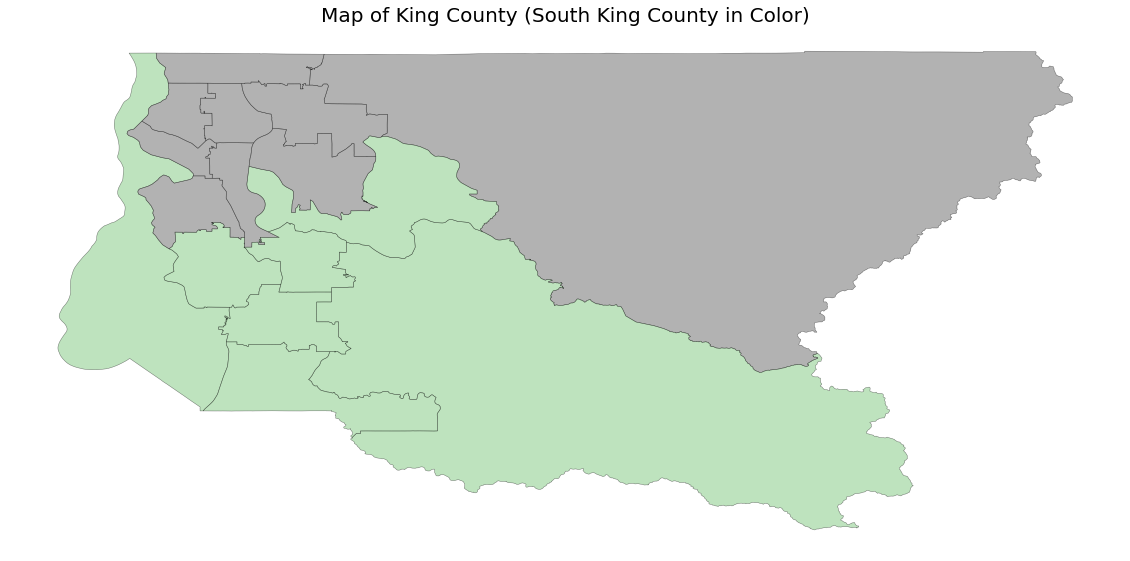

In [21]:
# Plots a map of King County, with South King County and South Seattle in color
fig, ax = plt.subplots(1, figsize=(20, 16))
ax = skc_puma.plot(ax=ax, 
              column='SKC', cmap='Accent_r', alpha = .5, linewidth=.5, edgecolor='black',  legend = False)
ax.set_title('Map of King County (South King County in Color)', fontsize = 20)
ax.set_axis_off()
fig.tight_layout
plt.show();